<a href="https://colab.research.google.com/github/HassanSuhaib71/Learn-Langgraph-With-Hassan/blob/main/20_module_3_3_edit_state_human_feedback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_google_genai langgraph_sdk

In [2]:
import os
from google.colab import userdata

%env GOOGLE_API_KEY = {userdata.get('GEMINI_API_KEY')}

%env LANGCHAIN_API_KEY = {userdata.get('LANGCHAIN_API_KEY')}
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

env: GOOGLE_API_KEY={userdata.get('GEMINI_API_KEY')}
env: LANGCHAIN_API_KEY={userdata.get('LANGCHAIN_API_KEY')}


In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.tools import tool

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools: list[tool] = [add, multiply, divide]
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model = "gemini-1.5-flash")
llm_with_tools = llm.bind_tools(tools)

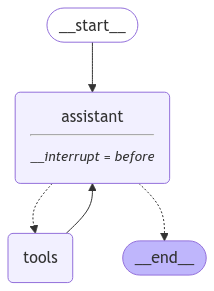

In [4]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.graph.state import CompiledStateGraph

from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder: StateGraph = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory: MemorySaver = MemorySaver()
graph: CompiledStateGraph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [5]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [6]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='f3f084d7-fc32-4907-b91e-769be7ca0d5c')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efe2ad5-1423-69cb-8000-ee1b7cb9f793'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': '1', 'step': 0, 'parents': {}}, created_at='2025-02-04T04:05:49.228872+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efe2ad5-1414-6efe-bfff-1b060e864f1b'}}, tasks=(PregelTask(id='8f123c79-85dc-a5bd-2d22-f0050e0dd5e9', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),))

In [7]:
state.next


('assistant',)

In [8]:
graph.update_state(
    thread,
    {"messages" : [HumanMessage(content ="no actually multiply 3 and 3")]}
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe2ad9-40aa-6bc0-8001-95a8768eadcb'}}

In [9]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

no actually multiply 3 and 3


In [10]:
graph.get_state(thread)


StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='f3f084d7-fc32-4907-b91e-769be7ca0d5c'), HumanMessage(content='no actually multiply 3 and 3', additional_kwargs={}, response_metadata={}, id='0c446385-4a99-4d4f-be37-b01770777b3b')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efe2ad9-40aa-6bc0-8001-95a8768eadcb'}}, metadata={'source': 'update', 'writes': {'__start__': {'messages': [HumanMessage(content='no actually multiply 3 and 3', additional_kwargs={}, response_metadata={}, id='0c446385-4a99-4d4f-be37-b01770777b3b')]}}, 'thread_id': '1', 'step': 1, 'parents': {}}, created_at='2025-02-04T04:07:41.272134+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efe2ad5-1423-69cb-8000-ee1b7cb9f793'}}, tasks=(PregelTask(id='9fb57434-c1dc-4767-72e9-45ef3102c563', name='assistant', path=('__pregel_pull', 'assistant'),

#With Langgraph Api

In [18]:
from langgraph_sdk import get_client
client = get_client(url="https://9941-39-33-6-198.ngrok-free.app")

In [19]:
initial_input = {"messages": "Multiply 2 and 3"}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=initial_input,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'abcfabfd-0e6a-4552-a1cd-81eebe861544', 'example': False}
--------------------------------------------------


In [20]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state

{'values': {'messages': [{'content': 'Multiply 2 and 3',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': 'abcfabfd-0e6a-4552-a1cd-81eebe861544',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': '6ee1cd5f-b503-57cf-53ef-2dd82d748ba8',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': None}],
 'metadata': {'step': 0,
  'run_id': '1efe2b5c-2dd7-6ac6-8587-dd3694756423',
  'source': 'loop',
  'writes': None,
  'parents': {},
  'user_id': '',
  'graph_id': 'agent',
  'thread_id': '8c8776c1-fff6-43c1-b3f5-d39d6967a7cb',
  'created_by': 'system',
  'run_attempt': 1,
  'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'langgraph_host': 'self-hosted',
  'langgraph_plan': 'developer',
  'x-forwarded-for': '35.245.98.124',
  'x-forwarded-host': '9941-39-33-6-198.ngrok-free.app',
  'langgraph_version': '0.2

In [21]:
last_message = current_state['values']['messages'][-1]
last_message

{'content': 'Multiply 2 and 3',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': 'abcfabfd-0e6a-4552-a1cd-81eebe861544',
 'example': False}

In [22]:
last_message['content'] = "No, actually multiply 3 and 3!"
last_message

{'content': 'No, actually multiply 3 and 3!',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': 'abcfabfd-0e6a-4552-a1cd-81eebe861544',
 'example': False}

In [23]:
last_message


{'content': 'No, actually multiply 3 and 3!',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': 'abcfabfd-0e6a-4552-a1cd-81eebe861544',
 'example': False}

In [24]:
await client.threads.update_state(thread['thread_id'], {"messages": last_message})


{'checkpoint': {'thread_id': '8c8776c1-fff6-43c1-b3f5-d39d6967a7cb',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe2b60-04ea-6367-8001-2934deec69c6'},
 'configurable': {'thread_id': '8c8776c1-fff6-43c1-b3f5-d39d6967a7cb',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe2b60-04ea-6367-8001-2934deec69c6'},
 'checkpoint_id': '1efe2b60-04ea-6367-8001-2934deec69c6'}

In [25]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'No, actually multiply 3 and 3!', 'additional_kwargs': {'additional_kwargs': {}, 'response_metadata': {}, 'example': False}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'abcfabfd-0e6a-4552-a1cd-81eebe861544', 'example': False}
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'function_call': {'name': 'multiply', 'arguments': '{"a": 3.0, "b": 3.0}'}}, 'response_metadata': {'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, 'type': 'ai', 'name': None, 'id': 'run-10cf32f0-9d9f-41f9-90a2-3a0d9de0fd3f-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 3.0, 'b': 3.0}, 'id': '997f587c-cf96-4c40-8ac8-736d96186b6f', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata'

In [26]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': '9', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '732c95aa-43ef-4c25-87b1-a75e92a8a86f', 'tool_call_id': '997f587c-cf96-4c40-8ac8-736d96186b6f', 'artifact': None, 'status': 'success'}
--------------------------------------------------
Receiving new event of type: values...
{'content': 'The result of multiplying 3 and 3 is 9.', 'additional_kwargs': {}, 'response_metadata': {'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, 'type': 'ai', 'name': None, 'id': 'run-6452e1fb-d5b5-4c61-9dc8-b94198db603e-0', 'example': False, 'tool_calls': [], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 74, 'output_tokens': 13, 'total_tokens': 87, 'input_token_details': {'cache_read': 0}}}
--------------------------------------------------


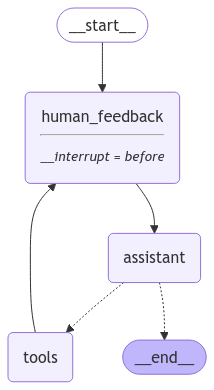

In [27]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# no-op node that should be interrupted on
def human_feedback(state: MessagesState):
    pass

# Assistant node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder: StateGraph = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

# Define edges: these determine the control flow
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "5"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

# Get user input
user_input = input("Tell me how you want to update the state: ")

# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"messages": user_input}, as_node="human_feedback")

# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


Tell me how you want to update the state: multiply 3 by 3
================================ Human Message =================================

multiply 3 by 3


ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 API key not valid. Please pass a valid API key. [reason: "API_KEY_INVALID"
domain: "googleapis.com"
metadata {
  key: "service"
  value: "generativelanguage.googleapis.com"
}
, locale: "en-US"
message: "API key not valid. Please pass a valid API key."
]

In [29]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

multiply 3 by 3


ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 API key not valid. Please pass a valid API key. [reason: "API_KEY_INVALID"
domain: "googleapis.com"
metadata {
  key: "service"
  value: "generativelanguage.googleapis.com"
}
, locale: "en-US"
message: "API key not valid. Please pass a valid API key."
]